In [1]:
import json
from collections import Counter
from utils import split_dict_train_test, PixelSetData, RandomSamplePixels, Normalize,\
    ToTensor, pad_sequences_collate_fn, PixelSetEncoder, TimeSeriesTransformer, SimpleMLP
import random
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch
import torch.nn as nn
from utils import trainer_function

Δημιουργία Dataset και Dataloaders

In [2]:
f_labels = open(r"Exercise4\timematch_data\denmark\32VNH\2017\meta\labels_cleaned.json")
labels_200 = json.load(f_labels)

print(len(labels_200), len(set(labels_200.values())))

count = 0
for lab in labels_200:
    print(lab, labels_200[lab])
    count += 1
    if count == 6:
        break

labels_200_counter = Counter(labels_200.values())

print()

for lab in labels_200_counter:
    print(lab, labels_200_counter[lab])

4255 7
0 corn
1 corn
2 corn
3 corn
4 corn
5 spring_barley

corn 275
spring_barley 1141
meadow 1013
winter_wheat 856
winter_rapeseed 301
winter_barley 352
winter_rye 317


In [3]:
# keep random subset of labels
labels_keys = list(labels_200.keys()) # indices 0, 1, 2 ...
labels_subset = random.sample(labels_keys, 150)
# print(labels_subset)
labels_subset = {key: labels_200[key] for key in labels_subset}

print(len(labels_subset), len(set(labels_subset.values())))

count = 0
for lab in labels_subset:
    print(lab, labels_subset[lab])
    count += 1
    if count == 9:
        break

labels_subset_counter = Counter(labels_subset.values())

print()

for lab in labels_subset_counter:
    print(lab, labels_subset_counter[lab])

150 7
2388 spring_barley
3385 winter_rye
3394 winter_rye
1246 winter_rye
998 winter_wheat
126 spring_barley
2795 spring_barley
1203 winter_wheat
1791 winter_barley

spring_barley 41
winter_rye 13
winter_wheat 27
winter_barley 16
meadow 32
corn 10
winter_rapeseed 11


In [4]:
labels_200 = labels_subset
labels_200_counter = labels_subset_counter

num_classes = len(labels_200_counter)

print(num_classes)

class_to_idx = {cls: idx for idx, cls in enumerate(labels_200_counter)}
for key, val in class_to_idx.items():
    print(key, val)

print()

# train_labels, val_labels = split_dict_train_test(labels_200, test_size=0.2)
train_labels, val_labels, test_labels = split_dict_train_test(labels_200, test_size=0.007, val_size=0.2)

print(len(labels_200))
print(len(train_labels))
print(len(val_labels))
print(len(test_labels))

7
spring_barley 0
winter_rye 1
winter_wheat 2
winter_barley 3
meadow 4
corn 5
winter_rapeseed 6

150
115
28
7


In [5]:
train_transform = transforms.Compose([RandomSamplePixels(32), Normalize(), ToTensor()])
test_transform = transforms.Compose([Normalize(), ToTensor()])

train_dataset = PixelSetData("Exercise4/timematch_data/denmark/32VNH/2017",
                             class_to_idx, train_labels,
                             train_transform)
val_dataset = PixelSetData("Exercise4/timematch_data/denmark/32VNH/2017",
                             class_to_idx, val_labels,
                             test_transform)
print(len(train_dataset))
print(len(val_dataset))

115
28


In [6]:
train_dloader = DataLoader(
    # train_dataset, batch_size=8, shuffle=True,
    train_dataset, batch_size=64, shuffle=True,
    collate_fn=pad_sequences_collate_fn,
)
val_dloader = DataLoader(
    val_dataset, batch_size=8, shuffle=True,
    collate_fn=pad_sequences_collate_fn,
)

print(len(train_dloader), len(val_dloader))

for batch in train_dloader:
    print(batch[0].shape)
    print(batch[1].shape)
    print(batch[1])
    print(batch[2].shape)
    print(np.unique(batch[2]))
    print()
    break

for batch in val_dloader:
    print(batch[0].shape)
    print(batch[1].shape)
    print(batch[1])
    print(batch[2].shape)
    print(np.unique(batch[2]))
    print()
    break

2 4
torch.Size([64, 52, 10, 32])
torch.Size([64])
tensor([6, 4, 3, 2, 0, 2, 1, 6, 4, 3, 0, 0, 3, 4, 5, 1, 3, 0, 1, 0, 0, 0, 0, 2,
        2, 2, 2, 0, 1, 2, 0, 4, 5, 0, 2, 0, 3, 6, 0, 4, 2, 4, 2, 4, 4, 6, 0, 0,
        0, 6, 5, 1, 4, 4, 2, 4, 0, 0, 1, 4, 0, 1, 4, 4])
torch.Size([64, 52, 32])
[ True]

torch.Size([8, 52, 10, 875])
torch.Size([8])
tensor([4, 1, 2, 0, 2, 2, 0, 4])
torch.Size([8, 52, 875])
[False  True]



In [7]:
pixel_encoder = PixelSetEncoder(10, mlp1=[10, 32],
                                    pooling="mean_std",
                                    mlp2=[64, 128])
transformer_encoder = TimeSeriesTransformer(d_model=128)
simple_mlp = SimpleMLP(input_dim=128, output_dim=7)

class CompleteModel(nn.Module):
    def __init__(self, pixel_encoder, transformer_encoder, simple_mlp):
        super(CompleteModel, self).__init__()
        self.pixel_encoder = pixel_encoder
        self.transformer_encoder = transformer_encoder
        self.simple_mlp = simple_mlp
    
    def forward(self, x, mask):
        x = self.pixel_encoder(x, mask)  # torch.Size([8, 52, 128])
        x = self.transformer_encoder(x)  # torch.Size([8, 128])
        x = self.simple_mlp(x) # torch.Size([8, 7])
        return x

model = CompleteModel(pixel_encoder, transformer_encoder, simple_mlp)

In [8]:
for batch in train_dloader:
    print(batch[0].shape)
    print(batch[2].shape)
    print()
    out = model(batch[0], batch[2])
    print(out.shape)
    break

torch.Size([64, 52, 10, 32])
torch.Size([64, 52, 32])

torch.Size([64, 7])


In [9]:
train_dloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=pad_sequences_collate_fn,
)

for batch in train_dloader:
    input_tensor = batch[0]
    labels = batch[1]
    mask = batch[2]

    print(input_tensor.shape)
    print(labels.shape)
    print(labels)
    print(mask.shape)
    print()

    break

out = model(input_tensor, mask)

print(out.shape)

print(out)

torch.Size([8, 52, 10, 32])
torch.Size([8])
tensor([0, 0, 0, 2, 4, 1, 0, 6])
torch.Size([8, 52, 32])

torch.Size([8, 7])
tensor([[-0.0565,  0.2578,  0.2917,  0.1691,  0.2128, -0.1286, -0.2001],
        [ 0.0710,  0.2255,  0.3139,  0.2607,  0.1405, -0.2200, -0.1312],
        [ 0.0381,  0.1973,  0.2648,  0.3262,  0.2396, -0.1278, -0.1468],
        [ 0.0691,  0.2140,  0.1939,  0.2959,  0.2298, -0.0979, -0.4176],
        [ 0.0532,  0.2405,  0.2660,  0.2394,  0.1938, -0.0126, -0.1433],
        [-0.0448,  0.1838,  0.3071,  0.1125,  0.1480, -0.1033, -0.2674],
        [ 0.0055,  0.2339,  0.2969,  0.1468,  0.1949, -0.1478, -0.1839],
        [-0.0035,  0.1982,  0.2857,  0.2806,  0.2522, -0.1063, -0.1204]],
       grad_fn=<AddmmBackward0>)


In [10]:
for batch in val_dloader:
    input_tensor = batch[0]
    labels = batch[1]
    mask = batch[2]

    print(input_tensor.shape)
    print(labels.shape)
    print(labels)
    print(mask.shape)
    print()

    break

out = model(input_tensor, mask)

print(out.shape)

print(out)

torch.Size([8, 52, 10, 461])
torch.Size([8])
tensor([6, 5, 0, 4, 2, 2, 0, 3])
torch.Size([8, 52, 461])

torch.Size([8, 7])
tensor([[-0.0132,  0.2008,  0.2356,  0.0404,  0.1173, -0.1232, -0.2029],
        [-0.0082,  0.2197,  0.2607,  0.1494,  0.2313, -0.0965, -0.2208],
        [-0.0382,  0.2112,  0.2581,  0.2475,  0.2022, -0.1235, -0.1841],
        [ 0.0881,  0.1856,  0.2746,  0.2022,  0.1258, -0.2047, -0.2409],
        [ 0.0015,  0.2965,  0.2578,  0.0941,  0.1651, -0.0666, -0.1213],
        [ 0.0226,  0.2430,  0.2943,  0.2342,  0.1632, -0.1558, -0.3984],
        [-0.0394,  0.2371,  0.2336,  0.4070,  0.3163, -0.1202, -0.4298],
        [-0.0296,  0.2776,  0.2987,  0.2272,  0.2462, -0.0298, -0.1697]],
       grad_fn=<AddmmBackward0>)


Trial Model

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

cpu
Number of parameters: 1796743


Epoch 0/2
----------
Loss: 1.8632 Acc: 0.2348
F1 Micro: 0.2348 F1 Weighted: 0.1512
Precision: 0.2348 Recall: 0.2348
Confusion Matrix:
tensor([[20,  0, 12,  0,  0,  0,  0],
        [ 3,  0,  7,  0,  0,  0,  0],
        [13,  1,  7,  0,  0,  0,  0],
        [ 5,  1,  6,  0,  0,  0,  0],
        [18,  0,  7,  0,  0,  0,  0],
        [ 5,  0,  2,  0,  0,  0,  0],
        [ 3,  0,  4,  0,  1,  0,  0]])
Validation Loss: 1.8245 Acc: 0.2857
Validation F1 Micro: 0.2857 F1 Weighted: 0.1270
Validation Precision: 0.2857 Recall: 0.2857
Validation Confusion Matrix:
tensor([[8, 0, 0, 0, 0, 0, 0],
        [2, 0, 0, 0, 0, 0, 0],
        [5, 0, 0, 0, 0, 0, 0],
        [3, 0, 0, 0, 0, 0, 0],
        [6, 0, 0, 0, 0, 0, 0],
        [2, 0, 0, 0, 0, 0, 0],
        [2, 0, 0, 0, 0, 0, 0]])
Epoch 1/2
----------
Loss: 1.8172 Acc: 0.2870
F1 Micro: 0.2870 F1 Weighted: 0.1387
Precision: 0.2870 Recall: 0.2870
Confusion Matrix:
tensor([[32,  0,  0,  0,  0,  0,  0],
        [10,  0,  0,  0,  0,  0,  0],
        [21,  

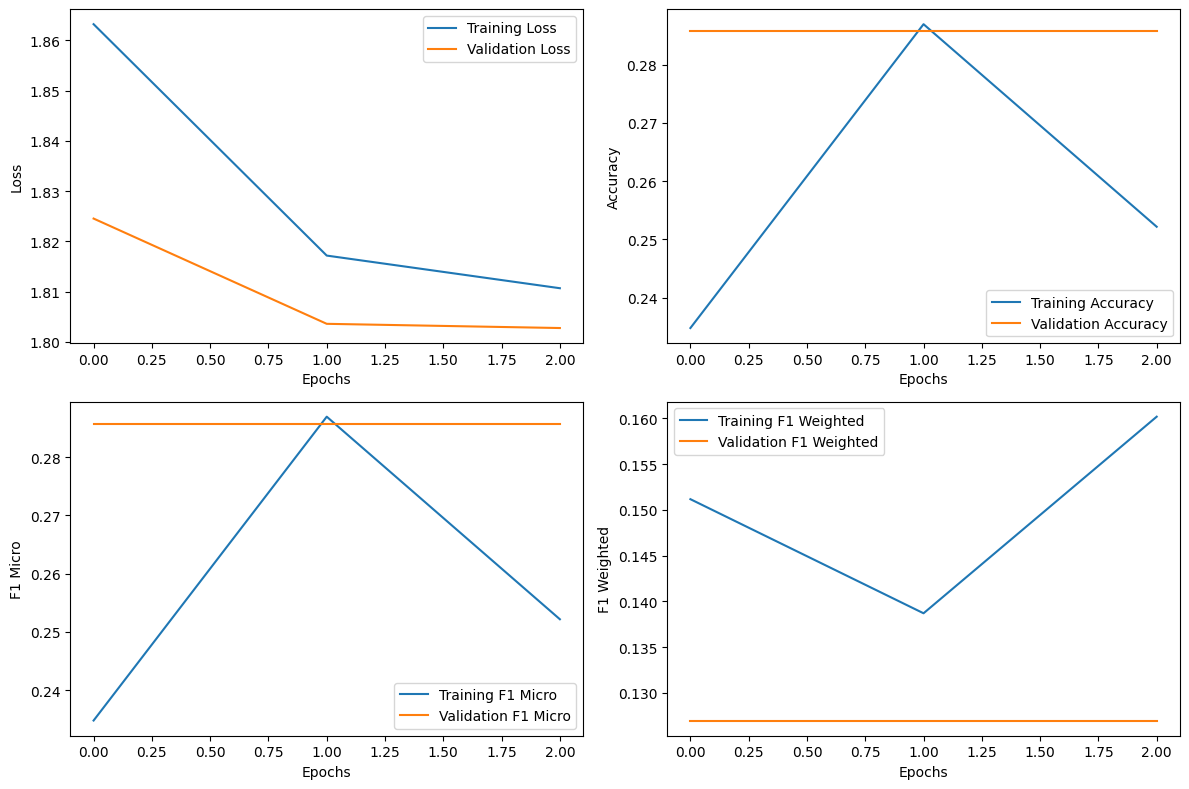

In [12]:
_ = trainer_function(model, num_classes, train_dloader, val_dloader, device, num_epochs=3)